In [25]:
import cv2
from imutils import face_utils
import pandas as pd
import numpy as np
import mediapipe as mp

import os
import re
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt


In [26]:
pack_identify = {
    "forehead_top": [10],  # —Å–∞–º–∞—è –≤–µ—Ä—Ö–Ω—è—è —Ç–æ—á–∫–∞ –≥–æ–ª–æ–≤—ã
    "chin_bottom": [152],  # –Ω–∏–∂–Ω—è—è —Ç–æ—á–∫–∞ –ø–æ–¥–±–æ—Ä–æ–¥–∫–∞
    "head_width": [234, 454],  # –∫—Ä–∞–π–Ω–∏–µ –±–æ–∫–æ–≤—ã–µ —Ç–æ—á–∫–∏ –ª–∏—Ü–∞ (–ª–µ–≤–æ/–ø—Ä–∞–≤–æ)
    "left_eyebrow_top": 70,
    "left_eye_center": 159,
    "right_eyebrow_top": 336,
    "right_eye_center": 386,
}

In [27]:
class Landmark():
    def __init__(self, x : int, y : int):
        self.x = x
        self.y = y

In [28]:
def segment_length(x1, y1, x2, y2):
    return math.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)


def point_to_line_distance(x0, y0, x1, y1, x2, y2):
    numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
    denominator = segment_length(x1, y1, x2, y2)
    if denominator == 0:
        raise ValueError("–¢–æ—á–∫–∏ x1,y1 –∏ x2,y2 —Å–æ–≤–ø–∞–¥–∞—é—Ç ‚Äî –Ω–µ–ª—å–∑—è –ø–æ—Å—Ç—Ä–æ–∏—Ç—å –ø—Ä—è–º—É—é.")
    return numerator / denominator, denominator / 2

def safe_relative_deviation(height, base, max_ratio=10.0):
    if base == 0:
        return max_ratio
    ratio = height / base
    return min(ratio, max_ratio)  # –∑–∞—â–∏—Ç–∞ –æ—Ç –≤–∑—Ä—ã–≤–∞ –º–µ—Ç—Ä–∏–∫–∏



In [29]:
def get_head_proportion(landmarks):
    # –¢–æ—á–∫–∏: –≤–µ—Ä—Ö –≥–æ–ª–æ–≤—ã (10), –ø–æ–¥–±–æ—Ä–æ–¥–æ–∫ (152), –∫—Ä–∞—è –≥–æ–ª–æ–≤—ã (234, 454)
    x_top = landmarks[10].x
    y_top = landmarks[10].y
    x_chin = landmarks[152].x
    y_chin = landmarks[152].y
    x_left = landmarks[234].x
    y_left = landmarks[234].y
    x_right = landmarks[454].x
    y_right = landmarks[454].y

    height = math.sqrt((x_top - x_chin)**2 + (y_top - y_chin)**2)
    width = math.sqrt((x_left - x_right)**2 + (y_left - y_right)**2)

    return safe_relative_deviation(height, width)


def forehead_is_vertical(landmarks, max_angle=30):
    # –í–µ—Ä—Ö–Ω—è—è —Ç–æ—á–∫–∞ –ª–±–∞
    x0 = landmarks[10].x
    y0 = landmarks[10].y

    # –ö—Ä–∞—è –ª–±–∞ / –≤–∏—Å–∫–æ–≤
    x1 = landmarks[234].x
    y1 = landmarks[234].y
    x2 = landmarks[454].x
    y2 = landmarks[454].y

    distance, _ = point_to_line_distance(x0, y0, x1, y1, x2, y2)

    # –¥–ª–∏–Ω–∞ –æ—Å–Ω–æ–≤–∞–Ω–∏—è (–¥–ª—è –Ω–∞—Ö–æ–∂–¥–µ–Ω–∏—è –æ—Ç–Ω–æ—à–µ–Ω–∏—è)
    base = segment_length(x1, y1, x2, y2)

    if base == 0:
        return False  # –Ω–µ–ª—å–∑—è —Å–∫–∞–∑–∞—Ç—å, –ª–∏–Ω–∏—è –≤—ã—Ä–æ–∂–¥–µ–Ω–∞

    ratio = distance / (base / 2)

    # –ß–µ–º –±–ª–∏–∂–µ –∫ —Ü–µ–Ω—Ç—Ä—É ‚Äî —Ç–µ–º –≤–µ—Ä—Ç–∏–∫–∞–ª—å–Ω–µ–µ
    return ratio < math.tan(math.radians(max_angle))


def get_avg_brow_height(landmarks):
    # –õ–µ–≤–∞—è –±—Ä–æ–≤—å –∏ –≥–ª–∞–∑: 70 (–≤–µ—Ä—Ö –±—Ä–æ–≤–∏), 159 (—Ü–µ–Ω—Ç—Ä –≥–ª–∞–∑–∞)
    # –ü—Ä–∞–≤–∞—è –±—Ä–æ–≤—å –∏ –≥–ª–∞–∑: 336 (–≤–µ—Ä—Ö –±—Ä–æ–≤–∏), 386 (—Ü–µ–Ω—Ç—Ä –≥–ª–∞–∑–∞)

    left_brow_y = landmarks[70].y
    left_eye_y = landmarks[159].y

    right_brow_y = landmarks[336].y
    right_eye_y = landmarks[386].y

    left_height = abs(left_brow_y - left_eye_y)
    right_height = abs(right_brow_y - right_eye_y)

    return (left_height + right_height) / 2



In [30]:
DATASET_ALL_DATA = r"E:\Project VS\Machine-Learning\all_data"

# –ó–∞–≥—Ä—É–∂–∞–µ–º –º–æ–¥–µ–ª—å
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)



In [31]:
def numeric_key(name):
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', name)]

In [32]:
def get_landmarks(image_path):
    image_array = np.fromfile(image_path, dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError("–ò–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –Ω–µ –∑–∞–≥—Ä—É–∂–µ–Ω–æ!")
            
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #height, width = image_rgb.shape[:2]

    # –î–µ—Ç–µ–∫—Ç–∏—Ä—É–µ–º –ª–∏—Ü–æ
    faces = face_mesh.process(image_rgb)

    if not faces.multi_face_landmarks:
        return

    shape = faces.multi_face_landmarks[0]

    return [Landmark(p.x, p.y) for p in shape.landmark]

In [33]:
head_ratios = []
brow_heights = []
forehead_angles = []
rationality_labels = []
all_devs = []


In [34]:
def build_dataframe_rationality(dataset_dir,
                                t_head_ratios,
                                f_head_ratios,
                                t_brow_heights,
                                f_brow_heights,
                                t_forehead_flags,
                                f_forehead_flags,
                                get_label_func=lambda k: k // 8):

    global all_devs, all_labels
    all_devs = []
    all_labels = []

    k = 0
    for label_dir in sorted(os.listdir(dataset_dir), key=numeric_key):
        label_path = os.path.join(dataset_dir, label_dir)
        if not os.path.isdir(label_path):
            continue

        for filename in os.listdir(label_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(label_path, filename)

                result = get_landmarks(image_path)
                if result is None:
                    continue
                landmarks = result

                # –ü—Ä–∏–∑–Ω–∞–∫–∏
                head_ratio = get_head_proportion(landmarks)
                brow_height = get_avg_brow_height(landmarks)
                forehead_is_vert = forehead_is_vertical(landmarks)

                # –ú–µ—Ç–∫–∞: 0 ‚Äì —Ä–∞—Ü–∏–æ–Ω–∞–ª, 1 ‚Äì –∏—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª
                label = get_label_func(k) % 2

                # –†–∞–∑–¥–µ–ª—è–µ–º –ø–æ –∫–ª–∞—Å—Å–∞–º
                if label == 0:
                    t_head_ratios.append(head_ratio)
                    t_brow_heights.append(brow_height)
                    t_forehead_flags.append(int(forehead_is_vert))
                else:
                    f_head_ratios.append(head_ratio)
                    f_brow_heights.append(brow_height)
                    f_forehead_flags.append(int(forehead_is_vert))

                # –î–æ–±–∞–≤–ª—è–µ–º –≤ –æ–±—â–∏–µ —Å–ø–∏—Å–∫–∏
                all_devs.append([head_ratio, brow_height, int(forehead_is_vert)])
                all_labels.append(label)

        k += 1


In [35]:
t_head_ratios = []         # –ü—Ä–æ–ø–æ—Ä—Ü–∏—è –≥–æ–ª–æ–≤—ã —É —Ä–∞—Ü–∏–æ–Ω–∞–ª–æ–≤
f_head_ratios = []         # –ü—Ä–æ–ø–æ—Ä—Ü–∏—è –≥–æ–ª–æ–≤—ã —É –∏—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª–æ–≤

t_brow_heights = []        # –í—ã—Å–æ—Ç–∞ –±—Ä–æ–≤–µ–π —É —Ä–∞—Ü–∏–æ–Ω–∞–ª–æ–≤
f_brow_heights = []        # –í—ã—Å–æ—Ç–∞ –±—Ä–æ–≤–µ–π —É –∏—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª–æ–≤

t_forehead_flags = []      # –í–µ—Ä—Ç–∏–∫–∞–ª—å–Ω–æ—Å—Ç—å –ª–±–∞ —É —Ä–∞—Ü–∏–æ–Ω–∞–ª–æ–≤ (True/False)
f_forehead_flags = []      # –í–µ—Ä—Ç–∏–∫–∞–ª—å–Ω–æ—Å—Ç—å –ª–±–∞ —É –∏—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª–æ–≤ (True/False)



In [36]:
build_dataframe_rationality(
    DATASET_ALL_DATA,
    t_head_ratios=t_head_ratios,
    f_head_ratios=f_head_ratios,
    t_brow_heights=t_brow_heights,
    f_brow_heights=f_brow_heights,
    t_forehead_flags=t_forehead_flags,
    f_forehead_flags=f_forehead_flags
)


In [37]:
print(f"–†–∞—Ü–∏–æ–Ω–∞–ª—ã (–≤–µ—Ä—Ç–∏–∫–∞–ª—å–Ω—ã–π –ª–æ–±) - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: {len(t_forehead_flags)}")
print(f"–ò—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª—ã (–ª–æ–± —Å—É–∂–∞–µ—Ç—Å—è) - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: {len(f_forehead_flags)}")

print(f"–†–∞—Ü–∏–æ–Ω–∞–ª—ã (–≤—ã—Å–æ–∫–∏–µ –±—Ä–æ–≤–∏) - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: {len(t_brow_heights)}")
print(f"–ò—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª—ã (–Ω–∏–∑–∫–∏–µ –±—Ä–æ–≤–∏) - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: {len(f_brow_heights)}")

print(f"–†–∞—Ü–∏–æ–Ω–∞–ª—ã (–≥–æ–ª–æ–≤–∞ –≤—ã—Ç—è–Ω—É—Ç–∞ –ø–æ –≤–µ—Ä—Ç–∏–∫–∞–ª–∏) - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: {len(t_head_ratios)}")
print(f"–ò—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª—ã (–≥–æ–ª–æ–≤–∞ –≤—ã—Ç—è–Ω—É—Ç–∞ –ø–æ –≥–æ—Ä–∏–∑–æ–Ω—Ç–∞–ª–∏) - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: {len(f_head_ratios)}")


–†–∞—Ü–∏–æ–Ω–∞–ª—ã (–≤–µ—Ä—Ç–∏–∫–∞–ª—å–Ω—ã–π –ª–æ–±) - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: 37705
–ò—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª—ã (–ª–æ–± —Å—É–∂–∞–µ—Ç—Å—è) - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: 31426
–†–∞—Ü–∏–æ–Ω–∞–ª—ã (–≤—ã—Å–æ–∫–∏–µ –±—Ä–æ–≤–∏) - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: 37705
–ò—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª—ã (–Ω–∏–∑–∫–∏–µ –±—Ä–æ–≤–∏) - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: 31426
–†–∞—Ü–∏–æ–Ω–∞–ª—ã (–≥–æ–ª–æ–≤–∞ –≤—ã—Ç—è–Ω—É—Ç–∞ –ø–æ –≤–µ—Ä—Ç–∏–∫–∞–ª–∏) - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: 37705
–ò—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª—ã (–≥–æ–ª–æ–≤–∞ –≤—ã—Ç—è–Ω—É—Ç–∞ –ø–æ –≥–æ—Ä–∏–∑–æ–Ω—Ç–∞–ª–∏) - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ: 31426


In [38]:
#t_avg_dev_mouth = sum(t_procents_mouth)/len(t_procents_mouth)


In [39]:
print(f"–°—Ä–µ–¥–Ω–µ–µ —Å–æ–æ—Ç–Ω–æ—à–µ–Ω–∏–µ –≤—ã—Å–æ—Ç—ã –∫ —à–∏—Ä–∏–Ω–µ –≥–æ–ª–æ–≤—ã (–†–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å): {sum(t_head_ratios) / len(t_head_ratios):.3f}")
print(f"–°—Ä–µ–¥–Ω–µ–µ —Å–æ–æ—Ç–Ω–æ—à–µ–Ω–∏–µ –≤—ã—Å–æ—Ç—ã –∫ —à–∏—Ä–∏–Ω–µ –≥–æ–ª–æ–≤—ã (–ò—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å): {sum(f_head_ratios) / len(f_head_ratios):.3f}")

–°—Ä–µ–¥–Ω–µ–µ —Å–æ–æ—Ç–Ω–æ—à–µ–Ω–∏–µ –≤—ã—Å–æ—Ç—ã –∫ —à–∏—Ä–∏–Ω–µ –≥–æ–ª–æ–≤—ã (–†–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å): 1.102
–°—Ä–µ–¥–Ω–µ–µ —Å–æ–æ—Ç–Ω–æ—à–µ–Ω–∏–µ –≤—ã—Å–æ—Ç—ã –∫ —à–∏—Ä–∏–Ω–µ –≥–æ–ª–æ–≤—ã (–ò—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å): 1.093


In [40]:
print(f"–°—Ä–µ–¥–Ω—è—è –≤—ã—Å–æ—Ç–∞ –±—Ä–æ–≤–µ–π (–†–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å): {sum(t_brow_heights) / len(t_brow_heights):.3f}")
print(f"–°—Ä–µ–¥–Ω—è—è –≤—ã—Å–æ—Ç–∞ –±—Ä–æ–≤–µ–π (–ò—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å): {sum(f_brow_heights) / len(f_brow_heights):.3f}")

–°—Ä–µ–¥–Ω—è—è –≤—ã—Å–æ—Ç–∞ –±—Ä–æ–≤–µ–π (–†–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å): 0.052
–°—Ä–µ–¥–Ω—è—è –≤—ã—Å–æ—Ç–∞ –±—Ä–æ–≤–µ–π (–ò—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å): 0.052


In [41]:
print(f"–î–æ–ª—è –≤–µ—Ä—Ç–∏–∫–∞–ª—å–Ω–æ–≥–æ –ª–±–∞ (–†–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å): {sum(t_forehead_flags) / len(t_forehead_flags):.3f}")
print(f"–î–æ–ª—è –≤–µ—Ä—Ç–∏–∫–∞–ª—å–Ω–æ–≥–æ –ª–±–∞ (–ò—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å): {sum(f_forehead_flags) / len(f_forehead_flags):.3f}")


–î–æ–ª—è –≤–µ—Ä—Ç–∏–∫–∞–ª—å–Ω–æ–≥–æ –ª–±–∞ (–†–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å): 0.016
–î–æ–ª—è –≤–µ—Ä—Ç–∏–∫–∞–ª—å–Ω–æ–≥–æ –ª–±–∞ (–ò—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å): 0.017


In [42]:
all_devs = []
all_labels = []

In [46]:
# –û–±—ä–µ–¥–∏–Ω—è–µ–º –ø—Ä–∏–∑–Ω–∞–∫–∏
head_ratios = t_head_ratios + f_head_ratios
brow_heights = t_brow_heights + f_brow_heights
forehead_flags = t_forehead_flags + f_forehead_flags

# –°–æ–∑–¥–∞–µ–º –º–µ—Ç–∫–∏ (0 ‚Äî Thinking, 1 ‚Äî Feeling)
all_labels = [0] * len(t_head_ratios) + [1] * len(f_head_ratios)

# –û–±—ä–µ–¥–∏–Ω—è–µ–º –≤—Å—ë –≤ all_devs –¥–ª—è –æ–±—â–µ–≥–æ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞
all_devs = list(zip(head_ratios, brow_heights, forehead_flags))


In [47]:
def create_dataframe(sequence, columns, labels):
    df = pd.DataFrame(sequence, columns=columns)
    df['label'] = labels
    df = df.sample(frac=1).reset_index(drop=True)
    return df
df_all = create_dataframe(all_devs, columns=columns_all, labels=all_labels)


In [49]:
# –û–±—ä—è–≤–∏–º —Å–ø–∏—Å–æ–∫ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
columns_all = ["head_ratio", "brow_height", "forehead_flag"]
head_ratios = t_head_ratios + f_head_ratios
brow_heights = t_brow_heights + f_brow_heights
forehead_flags = t_forehead_flags + f_forehead_flags

# –°–æ–∑–¥–∞–Ω–∏–µ DataFrame'–æ–≤ (—É—á—Ç–∏, —á—Ç–æ all_labels —É–∂–µ –¥–æ–ª–∂–µ–Ω –±—ã—Ç—å —Å—Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω —Ä–∞–Ω–µ–µ –ø—Ä–∏ —Å–±–æ—Ä–µ –¥–∞–Ω–Ω—ã—Ö)
df_all = create_dataframe(all_devs, columns=columns_all, labels=all_labels)

# –î–ª—è –∫–∞–∂–¥–æ–≥–æ –æ—Ç–¥–µ–ª—å–Ω–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞ (–æ–±–æ—Ä–∞—á–∏–≤–∞–µ–º –∑–Ω–∞—á–µ–Ω–∏—è –≤ —Å–ø–∏—Å–æ–∫ —Å–ø–∏—Å–∫–æ–≤, –µ—Å–ª–∏ —ç—Ç–æ –æ–¥–Ω–æ–º–µ—Ä–Ω—ã–π —Å–ø–∏—Å–æ–∫)
df_head_ratio = create_dataframe([[x] for x in head_ratios], columns=["head_ratio"], labels=all_labels)
df_brow_height = create_dataframe([[x] for x in brow_heights], columns=["brow_height"], labels=all_labels)
df_forehead_flag = create_dataframe([[x] for x in forehead_flags], columns=["forehead_flag"], labels=all_labels)

# –ü—Ä–æ–≤–µ—Ä–∫–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –ø–æ –º–µ—Ç–∫–∞–º
print(df_all["label"].unique())
print(df_all["label"].value_counts())

# –í—ã–≤–æ–¥ —Ñ–∏–Ω–∞–ª—å–Ω–æ–≥–æ DataFrame
df_all


[0 1]
label
0    37705
1    31426
Name: count, dtype: int64


head_ratio  brow_height  forehead_flag  label
0        0.850517     0.054370              0      0
1        1.061793     0.082047              0      1
2        1.149803     0.039879              0      1
3        1.203680     0.063586              0      0
4        1.253096     0.056567              0      1
...           ...          ...            ...    ...
69126    1.377206     0.060216              0      0
69127    0.856478     0.032223              0      1
69128    1.184029     0.048520              0      0
69129    1.186457     0.055451              0      0
69130    1.243871     0.060032              0      0

[69131 rows x 4 columns]

In [51]:
df_all['label'].value_counts(normalize=True)


label
0    0.545414
1    0.454586
Name: proportion, dtype: float64

In [52]:
df_head_ratio

head_ratio  label
0        1.165753      0
1        1.271185      1
2        1.212458      1
3        1.149467      0
4        1.208998      1
...           ...    ...
69126    1.272211      1
69127    0.911858      0
69128    1.241712      0
69129    1.022386      1
69130    0.845756      1

[69131 rows x 2 columns]

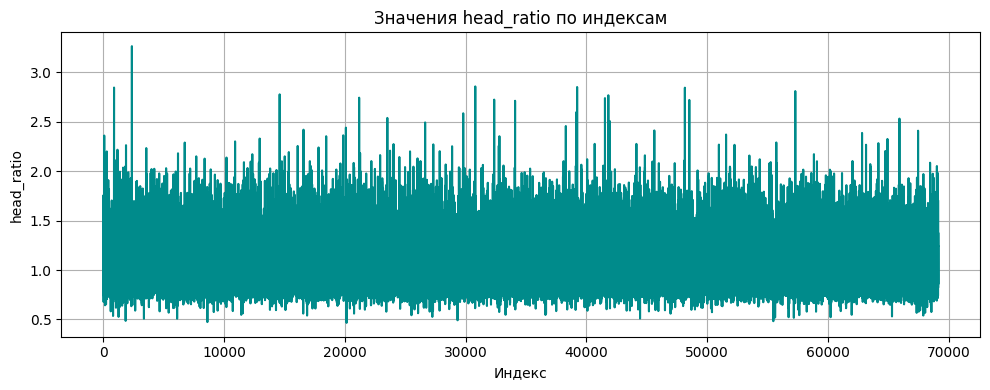

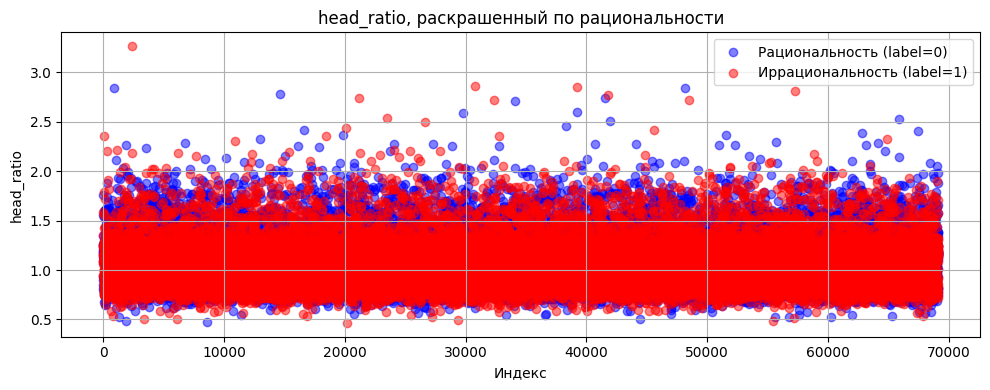

C:\Users\cepib\AppData\Local\Temp\ipykernel_16648\41403275.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_all, x="label", y="brow_height", palette="Set1", jitter=True, alpha=0.5)


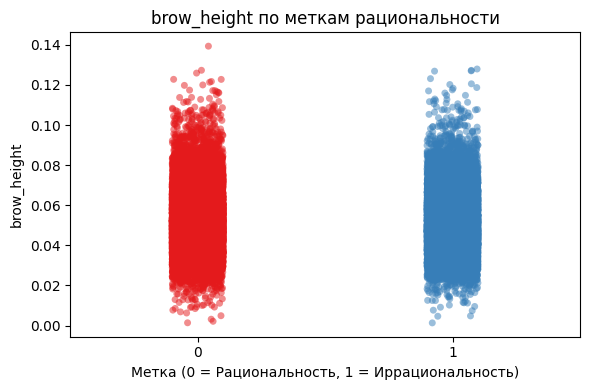

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# üìà –ì—Ä–∞—Ñ–∏–∫ head_ratio –ø–æ –∏–Ω–¥–µ–∫—Å–∞–º
plt.figure(figsize=(10, 4))
plt.plot(df_all['head_ratio'], color='darkcyan')
plt.title('–ó–Ω–∞—á–µ–Ω–∏—è head_ratio –ø–æ –∏–Ω–¥–µ–∫—Å–∞–º')
plt.xlabel('–ò–Ω–¥–µ–∫—Å')
plt.ylabel('head_ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

# üü¶üü• –¢–æ—á–∫–∏ head_ratio —Å –º–µ—Ç–∫–∞–º–∏ –†–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å (0) –∏ –ò—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å (1)
df_0 = df_all[df_all["label"] == 0]["head_ratio"]
df_1 = df_all[df_all["label"] == 1]["head_ratio"]

plt.figure(figsize=(10, 4))
plt.scatter(df_0.index, df_0, color='blue', label='–†–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å (label=0)', alpha=0.5)
plt.scatter(df_1.index, df_1, color='red', label='–ò—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å (label=1)', alpha=0.5)
plt.title("head_ratio, —Ä–∞—Å–∫—Ä–∞—à–µ–Ω–Ω—ã–π –ø–æ —Ä–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏")
plt.xlabel("–ò–Ω–¥–µ–∫—Å")
plt.ylabel("head_ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# üìä Stripplot –¥–ª—è brow_height
plt.figure(figsize=(6, 4))
sns.stripplot(data=df_all, x="label", y="brow_height", palette="Set1", jitter=True, alpha=0.5)
plt.title("brow_height –ø–æ –º–µ—Ç–∫–∞–º —Ä–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏")
plt.xlabel("–ú–µ—Ç–∫–∞ (0 = –†–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å, 1 = –ò—Ä—Ä–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å)")
plt.ylabel("brow_height")
plt.tight_layout()
plt.show()


In [59]:
print(df_all.columns)


Index(['head_ratio', 'brow_height', 'forehead_flag', 'label'], dtype='object')


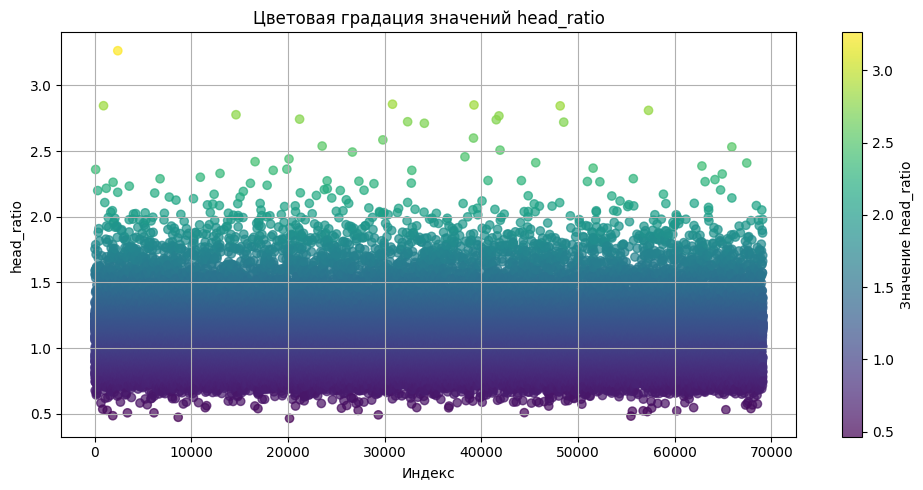

In [60]:
# –û—Ç–æ–±—Ä–∞–∑–∏–º –∑–Ω–∞—á–µ–Ω–∏—è head_ratio –ø–æ –∏–Ω–¥–µ–∫—Å—É —Å —Ü–≤–µ—Ç–æ–≤–æ–π –≥—Ä–∞–¥–∞—Ü–∏–µ–π –ø–æ —Å–∞–º–æ–º—É –∑–Ω–∞—á–µ–Ω–∏—é
plt.figure(figsize=(10, 5))
scatter = plt.scatter(df_all.index, df_all['head_ratio'], c=df_all['head_ratio'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='–ó–Ω–∞—á–µ–Ω–∏–µ head_ratio')  # —Ü–≤–µ—Ç–æ–≤–∞—è —à–∫–∞–ª–∞
plt.xlabel('–ò–Ω–¥–µ–∫—Å')
plt.ylabel('head_ratio')
plt.title('–¶–≤–µ—Ç–æ–≤–∞—è –≥—Ä–∞–¥–∞—Ü–∏—è –∑–Ω–∞—á–µ–Ω–∏–π head_ratio')
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def agg_train_test_split(df: pd.DataFrame):
    return train_test_split(
        df.drop(columns=['label']),  # –≤—Å–µ –∫–æ–ª–æ–Ω–∫–∏ –∫—Ä–æ–º–µ 'label'
        df['label'],                 # —Å–∞–º–∏ –º–µ—Ç–∫–∏
        test_size=0.2,               # 20% –Ω–∞ —Ç–µ—Å—Ç
        stratify=df['label'],        # —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω–∞—è —Ä–∞–∑–±–∏–≤–∫–∞ –ø–æ –∫–ª–∞—Å—Å–∞–º (–∏—Å–ø—Ä–∞–≤–∏–ª —Å df_all –Ω–∞ df)
        random_state=42
    )

def create_model(x_train, y_train):
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    return model


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def agg_train_test_split(df: pd.DataFrame):
    return train_test_split(
        df.drop(columns=['label']),   # –í—Å–µ –ø—Ä–∏–∑–Ω–∞–∫–∏, –∫—Ä–æ–º–µ –º–µ—Ç–∫–∏
        df['label'],                  # –¶–µ–ª–µ–≤—ã–µ –º–µ—Ç–∫–∏
        test_size=0.2,                # 20% –Ω–∞ —Ç–µ—Å—Ç
        stratify=df['label'],         # –ë–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∫–∞ –∫–ª–∞—Å—Å–æ–≤
        random_state=42
    )

def create_model(x_train, y_train):
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    return model

# –î–µ–ª–∏–º –¥–∞–Ω–Ω—ã–µ
X_train_all, X_test_all, y_train_all, y_test_all = agg_train_test_split(df_all)
X_train_mouth, X_test_mouth, y_train_mouth, y_test_mouth = agg_train_test_split(df_head_ratio)
X_train_brows, X_test_brows, y_train_brows, y_test_brows = agg_train_test_split(df_brow_height)
X_train_jawline, X_test_jawline, y_train_jawline, y_test_jawline = agg_train_test_split(df_forehead_flag)

# –û–±—É—á–∞–µ–º –º–æ–¥–µ–ª–∏
model_all = create_model(X_train_all, y_train_all)
model_mouth = create_model(X_train_mouth, y_train_mouth)
model_brows = create_model(X_train_brows, y_train_brows)
model_jawline = create_model(X_train_jawline, y_train_jawline)

# –ü—Ä–µ–¥—Å–∫–∞–∑—ã–≤–∞–µ–º
y_pred_all = model_all.predict(X_test_all)
y_pred_mouth = model_mouth.predict(X_test_mouth)
y_pred_brows = model_brows.predict(X_test_brows)
y_pred_jawline = model_jawline.predict(X_test_jawline)

# –í—ã–≤–æ–¥–∏–º —Ç–æ—á–Ω–æ—Å—Ç—å
print(f"–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –Ω–∞ –≤—Å–µ—Ö –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö: {accuracy_score(y_test_all, y_pred_all):.4f}")
print(f"–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –Ω–∞ –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö —Ä—Ç–∞: {accuracy_score(y_test_mouth, y_pred_mouth):.4f}")
print(f"–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –Ω–∞ –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö –±—Ä–æ–≤–µ–π: {accuracy_score(y_test_brows, y_pred_brows):.4f}")
print(f"–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –Ω–∞ –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö –ª–∏–Ω–∏–∏ —á–µ–ª—é—Å—Ç–∏: {accuracy_score(y_test_jawline, y_pred_jawline):.4f}")


–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –Ω–∞ –≤—Å–µ—Ö –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö: 0.5454
–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –Ω–∞ –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö —Ä—Ç–∞: 0.5454
–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –Ω–∞ –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö –±—Ä–æ–≤–µ–π: 0.5454
–¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –Ω–∞ –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö –ª–∏–Ω–∏–∏ —á–µ–ª—é—Å—Ç–∏: 0.5454


In [63]:
print("–ö–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç—ã:", model_all.coef_)
print("–°–º–µ—â–µ–Ω–∏–µ:", model_all.intercept_)

–ö–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç—ã: [[-0.24227347  2.01688997  0.03623825]]
–°–º–µ—â–µ–Ω–∏–µ: [-0.02184821]


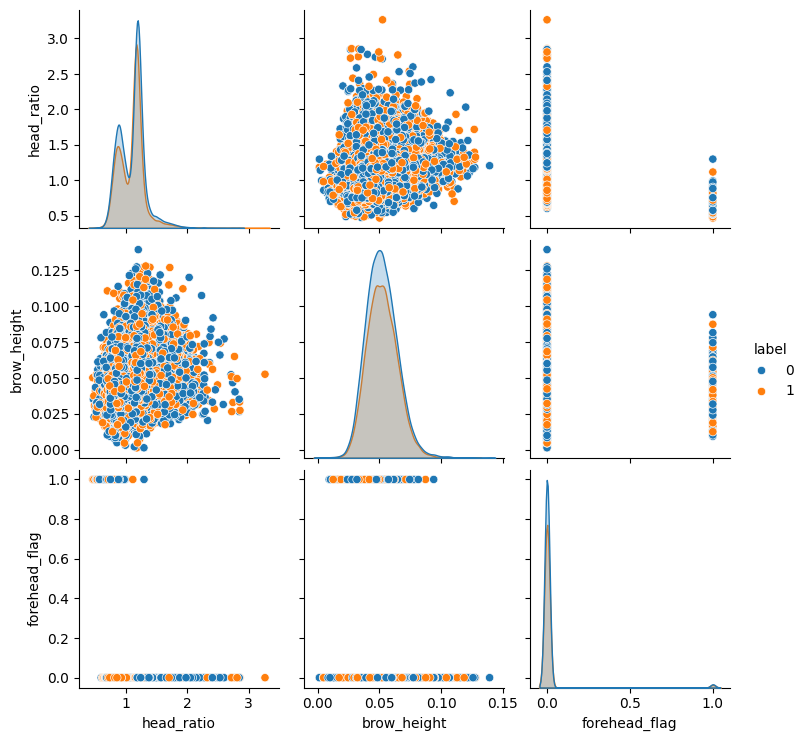

In [64]:
sns.pairplot(df_all, hue='label')

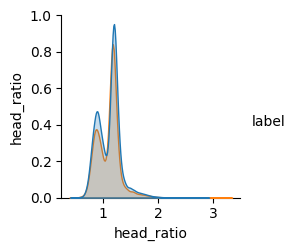

In [65]:
sns.pairplot(df_head_ratio, hue='label')

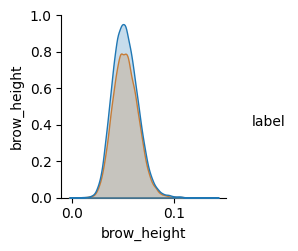

In [66]:
sns.pairplot(df_brow_height, hue='label')

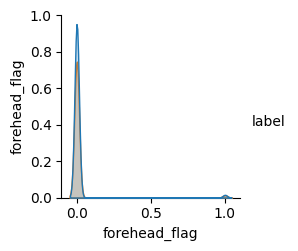

In [67]:
sns.pairplot(df_forehead_flag, hue='label')